In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
test_transform = transforms.Compose([
        # Requirements for pretrained models:
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [11]:
from torch.utils.data import Dataset
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, task, part, root_dir, label_file, class_names, class_to_idx, transform):
        self.root_dir = root_dir
        self.label_file = label_file
        self.class_names = class_names
        self.class_to_idx = class_to_idx
        self.transform = transform

        # Read the labels from the Excel file
        if (task == 'A' and part == 1): 
            self.labels = pd.read_csv('./Datasets/celeba_test/labels.csv', usecols=[2], delimiter='\t')['gender'].tolist()
        if (task == 'A' and part == 2):
            self.labels = pd.read_csv('./Datasets/celeba_test/labels.csv', usecols=[3], delimiter='\t')['smiling'].tolist()
        if (task == 'B' and part == 1): 
            self.labels = pd.read_csv('./Datasets/cartoon_set_test/labels.csv', usecols=[2])['face_shape'].tolist()
        if (task == 'B' and part == 2):
            self.labels = pd.read_csv('./Datasets/cartoon_set_test/labels.csv', usecols=[1])['eye_color'].tolist()
        
        # Get the list of image files (without the lambda it was not in order)
        self.image_files = []
        for root, dirs, files in os.walk(root_dir): 
            self.image_files.extend([os.path.join(root, file) for file in sorted(files, key=lambda x: int(''.join(filter(str.isdigit, x))))])


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load the image and apply the transformation
        image = Image.open(self.image_files[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Convert the label to a tensor
        label = torch.tensor(self.labels[idx])
        
        return image, label

# Define the root directory of the dataset and the label file
root_dir_test = './Datasets/celeba_test/img'
root_dir_testB = './Datasets/cartoon_set_test/img'
# Define the class names and their corresponding indexes
class_names = ['men', 'women']
class_to_idx = {'men': 1, 'women': -1}
class_names2 = ['Shape0', 'Shape1', 'Shape2', 'Shape3', 'Shape4']
class_to_idx2 = {'Shape0': 0, 'Shape1': 1, 'Shape2': 2, 'Shape3': 3, 'Shape4': 4}

A1test_data = MyDataset('A', 1, root_dir_test, label_file_test, class_names, class_to_idx, transform=test_transform)
A2test_data = MyDataset('A', 2, root_dir_test, label_file_test, class_names, class_to_idx, transform=test_transform)
B1test_data = MyDataset('B', 1, root_dir_testB, label_file_test, class_names2, class_to_idx2, transform=test_transform)
B2test_data = MyDataset('B', 2, root_dir_testB, label_file_test, class_names2, class_to_idx2, transform=test_transform)

torch.manual_seed(42)

A1test_loader = DataLoader(A1test_data, batch_size=125, shuffle=True)
A2test_loader = DataLoader(A2test_data, batch_size=125, shuffle=True)
B1test_loader = DataLoader(B1test_data, batch_size=125, shuffle=True)
B2test_loader = DataLoader(B2test_data, batch_size=125, shuffle=True)

# A1


In [52]:
A1model = models.regnet_y_16gf()
A1model.fc = nn.Sequential(nn.Linear(3024,1000),nn.Linear(1000,2),nn.LogSoftmax(dim=1))
A1model.load_state_dict(torch.load('./A1/A1RegnetY16GFModel.pt'))

<All keys matched successfully>

In [6]:
actual = []
predictions = []

# Run the testing batches
with torch.no_grad():
    for b, (X_test, y_test) in enumerate(A1test_loader):
        # Changing the labels to be in the range [0, num_classes-1].
        y_test = torch.where(y_test == 1, torch.tensor(1), torch.tensor(0))

        actual.append(y_test)

        # Apply the model
        y_val = A1model(X_test)

        # Tally the number of correct predictions
        predicted = torch.max(y_val.data, 1)[1]
        predictions.append(predicted)

In [14]:
preds = []
for tensor in predictions:
    preds.append(tensor.tolist())

act = []
for tensor in actual:
    act.append(tensor.tolist())

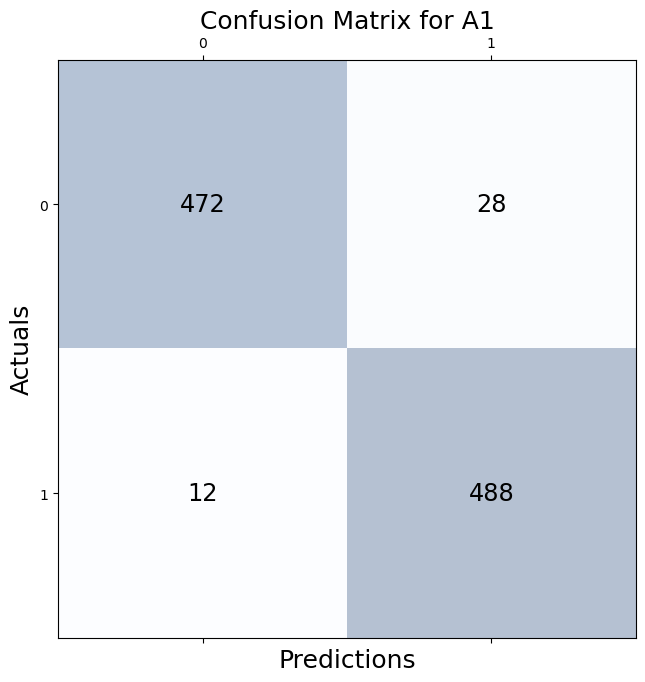

In [26]:
from sklearn.metrics import confusion_matrix

#Converting tensors to list
preds = []
for tensor in predictions:
    preds.append(tensor.tolist())

act = []
for tensor in actual:
    act.append(tensor.tolist())


act = np.reshape(np.array(act), (1000,))
preds = np.reshape(np.array(preds), (1000,))

conf_matrix = confusion_matrix(y_true=act, y_pred=preds)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for A1', fontsize=18)
plt.show()

# A2


In [4]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        # (((178−2)/2)−2)/2=43
        # (((218−2)/2)−2)/2=53
        self.fc1 = nn.Linear(43*53*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 43*53*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

A2model = ConvolutionalNetwork()
A2model.load_state_dict(torch.load('./A2/A2CNNModelFinal.pt'))

<All keys matched successfully>

In [5]:
actual = []
predictions = []

# Run the testing batches
with torch.no_grad():
    for b, (X_test, y_test) in enumerate(A2test_loader):
        # Changing the labels to be in the range [0, num_classes-1].
        y_test = torch.where(y_test == 1, torch.tensor(1), torch.tensor(0))

        actual.append(y_test)

        # Apply the model
        y_val = A2model(X_test)

        # Tally the number of correct predictions
        predicted = torch.max(y_val.data, 1)[1]
        predictions.append(predicted)

In [29]:
actual2 = []
predictions2 = []

# Run the testing batches
with torch.no_grad():
    for b, (X_test, y_test) in enumerate(A2test_loader):
        # Changing the labels to be in the range [0, num_classes-1].
        y_test = torch.where(y_test == 1, torch.tensor(1), torch.tensor(0))

        actual2.append(y_test)

        # Apply the model
        y_val = A2model(X_test)

        # Tally the number of correct predictions
        predicted = torch.max(y_val.data, 1)[1]
        predictions2.append(predicted)

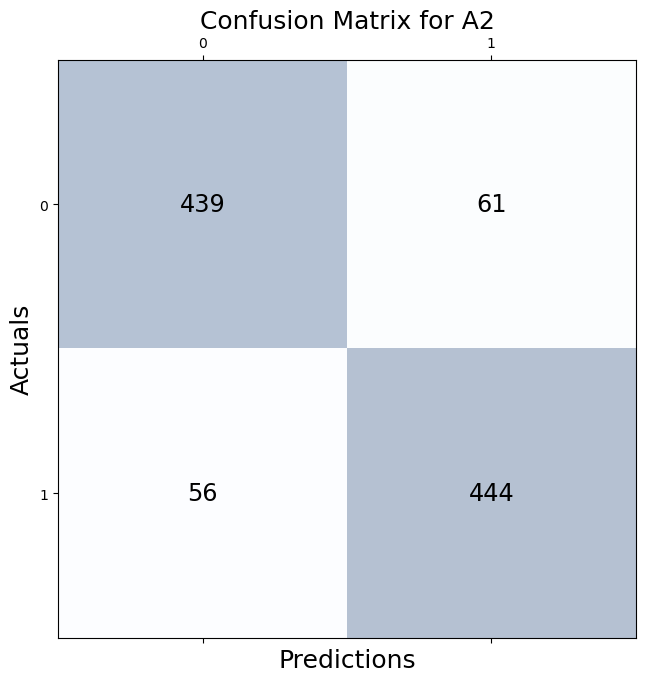

In [32]:
from sklearn.metrics import confusion_matrix

#Converting tensors to list
preds = []
for tensor in predictions2:
    preds.append(tensor.tolist())

act = []
for tensor in actual2:
    act.append(tensor.tolist())


act = np.reshape(np.array(act), (1000,))
preds = np.reshape(np.array(preds), (1000,))

conf_matrix = confusion_matrix(y_true=act, y_pred=preds)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for A2', fontsize=18)
plt.show()

# B1

In [19]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        # (((500−2)/2)−2)/2=123.5
        # (((500−2)/2)−2)/2=123.5
        self.fc1 = nn.Linear(123*123*16, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 5)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 123*123*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

B1model = ConvolutionalNetwork()
B1model.load_state_dict(torch.load('./B2/B2CNNModelFinal.pt'))

<All keys matched successfully>

In [20]:
actual3 = []
predictions3 = []

# Run the testing batches
with torch.no_grad():
    for b, (X_test, y_test) in enumerate(B1test_loader):
        
        actual3.append(y_test)

        # Apply the model
        y_val = B1model(X_test)

        # Tally the number of correct predictions
        predicted = torch.max(y_val.data, 1)[1]
        predictions3.append(predicted)

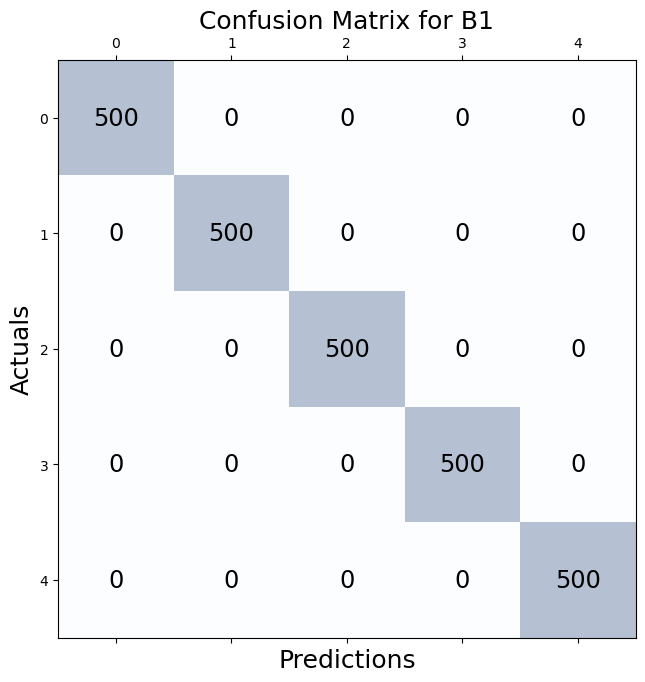

In [22]:
from sklearn.metrics import confusion_matrix

#Converting tensors to list
preds = []
for tensor in predictions3:
    preds.append(tensor.tolist())

act = []
for tensor in actual3:
    act.append(tensor.tolist())


act = np.reshape(np.array(act), (2500,))
preds = np.reshape(np.array(preds), (2500,))

conf_matrix = confusion_matrix(y_true=act, y_pred=preds)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for B1', fontsize=18)
plt.show()

# B2

In [23]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        # (((500−2)/2)−2)/2=123.5
        # (((500−2)/2)−2)/2=123.5
        self.fc1 = nn.Linear(123*123*16, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 5)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 123*123*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

B2model = ConvolutionalNetwork()
B2model.load_state_dict(torch.load('./B1/B2CNNModelFinal.pt'))


<All keys matched successfully>

In [24]:
actual4 = []
predictions4 = []

# Run the testing batches
with torch.no_grad():
    for b, (X_test, y_test) in enumerate(B2test_loader):
        actual4.append(y_test)

        # Apply the model
        y_val = B2model(X_test)

        # Tally the number of correct predictions
        predicted = torch.max(y_val.data, 1)[1]
        predictions4.append(predicted)

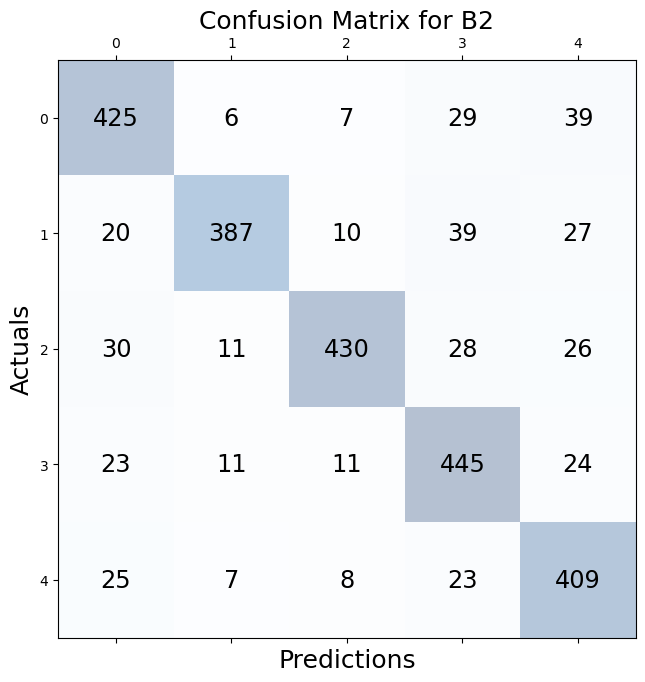

In [25]:
from sklearn.metrics import confusion_matrix

#Converting tensors to list
preds = []
for tensor in predictions4:
    preds.append(tensor.tolist())

act = []
for tensor in actual4:
    act.append(tensor.tolist())


act = np.reshape(np.array(act), (2500,))
preds = np.reshape(np.array(preds), (2500,))

conf_matrix = confusion_matrix(y_true=act, y_pred=preds)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for B2', fontsize=18)
plt.show()